In [17]:
import pandas as pd
import os
import numpy as np
from binance.client import Client
from datetime import date, datetime, timedelta, UTC
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
client = Client()
os.makedirs(os.path.join('..', 'charts'), exist_ok=True)

In [19]:
def get_binance_data(symbol='BTCUSDT', interval='5m', lookback = '12 days'):
    now = datetime.now(UTC)
    past = now - pd.to_timedelta(lookback)

    df = pd.DataFrame(client.get_historical_klines(symbol, interval, str(past), str(now)
    ), columns=['open_time','Open', 'High', 'Low', 'Close', 'Volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol','is_best_match'])
    
    df['Date']= pd.to_datetime(df['close_time'], unit='ms')
    return df[['Date','Open', 'High', 'Low', 'Close', 'Volume']]  


def safe_get_binance_data(symbol='BTCUSDT', interval='5m', lookback = '12 days', max_retries=10, base_delay=5):
    retries = 0
    while True:
        try:
            return get_binance_data(interval=interval, lookback=lookback)
        except Exception as e:
            retries += 1
            if retries >= max_retries:
                raise RuntimeError(f"Max retries reached. Last error: {e}")
            delay = base_delay * (2 ** (retries - 1))  # Exponential backoff
            print(f"Error: {e}. Retrying in {delay} sec...")
            time.sleep(delay)


In [20]:
%%time
symbol='BTCUSDT'
data = safe_get_binance_data(symbol=symbol, interval='5m', lookback = '20 days')
data.to_csv('Data_set_for_analitics_5min.csv')

CPU times: user 57.6 ms, sys: 2.3 ms, total: 60 ms
Wall time: 3.25 s


In [21]:
# Step 1: Clean raw data
df_train = data[['Date', 'Close']].dropna(subset=['Close']).copy()

# Step 2: Ensure correct data types
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.astype({'Close': 'float'})

# Step 3: Rename columns for Prophet
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})

# Step 4: Remove extreme outliers
q_low = df_train['y'].quantile(0.005)
q_high = df_train['y'].quantile(0.995)
df_train = df_train[(df_train['y'] >= q_low) & (df_train['y'] <= q_high)]

df_train = df_train.iloc[-3000:].copy().reset_index(drop=True) #drop=True prevents it from being added as a column


17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing


MAE = 167.01966744216682
Percent mae = 0.15445911200637696
RMSE = 250.66257561058717


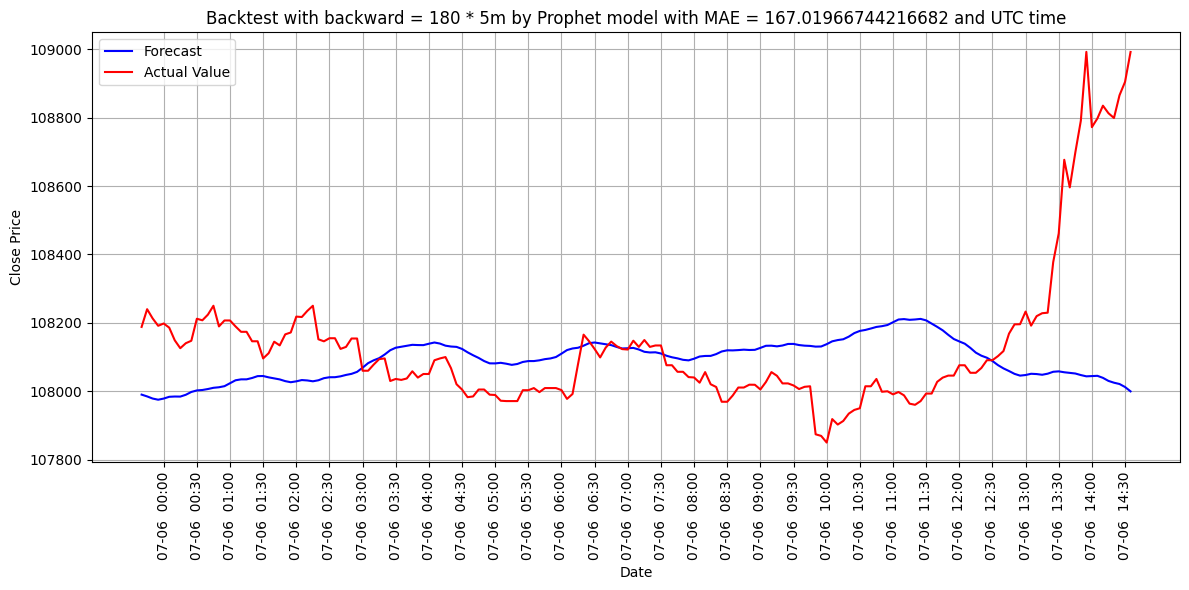

In [9]:
#Backtesting
horizont = 180
df_train = data[['Date', 'Close']].dropna(subset=['Close']).copy()
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.astype({'Close': 'float'})
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})
q_low = df_train['y'].quantile(0.005)
q_high = df_train['y'].quantile(0.995)
df_train = df_train[(df_train['y'] >= q_low) & (df_train['y'] <= q_high)]

df_test = df_train.iloc[-3000:-horizont].copy()

df_train = df_train.iloc[-3000:].copy()

model_param ={
    "n_changepoints": 10, # fewer changepoints speed up predictions
    "daily_seasonality": True,
    "weekly_seasonality": False,
    "yearly_seasonality": False,
    "seasonality_mode": "multiplicative",
    "changepoint_prior_scale": 0.1,
    "seasonality_prior_scale": 1,
    "holidays_prior_scale": 1,
    "growth": "logistic" #or linear.Then will need to delete cap paremeter/linear is by default
}
m = Prophet(**model_param)  #**model_param
df_test['cap']= df_test["y"].max() + df_test["y"].std() * 0.05
m.add_country_holidays(country_name='US')
m.add_seasonality(name='dayly', period=1, fourier_order=10)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_seasonality(name='hourly', period=1/24, fourier_order=3)
m.fit(df_test) 
future = m.make_future_dataframe(periods=horizont, freq='5min') #5 minutes
future['cap'] = df_test['cap'].max()
forecast = m.predict(future)

true_y = df_train['y'].iloc[-horizont:]
predict_y = forecast['yhat'].iloc[-horizont:]

mae = mean_absolute_error(true_y, predict_y) # mean absolute error
percent_mae = (mae / np.mean(true_y)) * 100
rmse = np.sqrt(mean_squared_error(true_y, predict_y))  # Root Mean Squared Error
print(f'MAE = {mae}')
print(f'Percent mae = {percent_mae}')
print(f'RMSE = {rmse}')

plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'].iloc[-horizont:], forecast['yhat'].iloc[-horizont:], 'b-', label='Forecast')
plt.plot(df_train['ds'].iloc[-horizont:], df_train['y'].iloc[-horizont:], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')

tick_dates= pd.date_range(start = forecast['ds'].iloc[-horizont:].min().ceil('30 min'), 
                          end = forecast['ds'].iloc[-horizont:].max().floor('30 min'), 
                          periods = 30)
plt.xticks(tick_dates, rotation=90)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d  %H:%M'))

plt.ylabel('Close Price')
plt.title(f'Backtest with backward = {horizont} * 5m by Prophet model with MAE = {mae} and UTC time')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [22]:
# Forecasting
## Creating model parameters
model_param ={
    "n_changepoints": 10, # fewer changepoints speed up predictions
    "daily_seasonality": True,
    "weekly_seasonality": False,
    "yearly_seasonality": False,
    "seasonality_mode": "multiplicative",
    "changepoint_prior_scale": 0.1,
    "seasonality_prior_scale": 1.0,
    "holidays_prior_scale": 1.0,
    "growth": "logistic" #or linear.Then will need to delete cap paremeter/linear is by default
}
m = Prophet(**model_param)  #**model_param
df_train['cap']= df_train["y"].max() + df_train["y"].std() * 0.05
m.add_country_holidays(country_name='US')
m.add_seasonality(name='dayly', period=1, fourier_order=10)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_seasonality(name='hourly', period=1/24, fourier_order=3) 
m.fit(df_train) # Train on the training set
future = m.make_future_dataframe(periods=90, freq='5min') #5 minutes
future['cap'] = df_train['cap'].max()
forecast = m.predict(future)
#forecast['yhat'] = savgol_filter(forecast['yhat'], window_length=21, polyorder=2) # to make the yhat smoother
mae = mean_absolute_error(df_train['y'].iloc[-270:], forecast['yhat'].iloc[-360:-90]) # mae by last 22.5 hours before forecast 
mae 


17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing


135.7376993745939

In [23]:
result = forecast.merge(
    data[['Date', 'Close']], 
    left_on='ds',         
    right_on='Date',       
    how='left'               
)

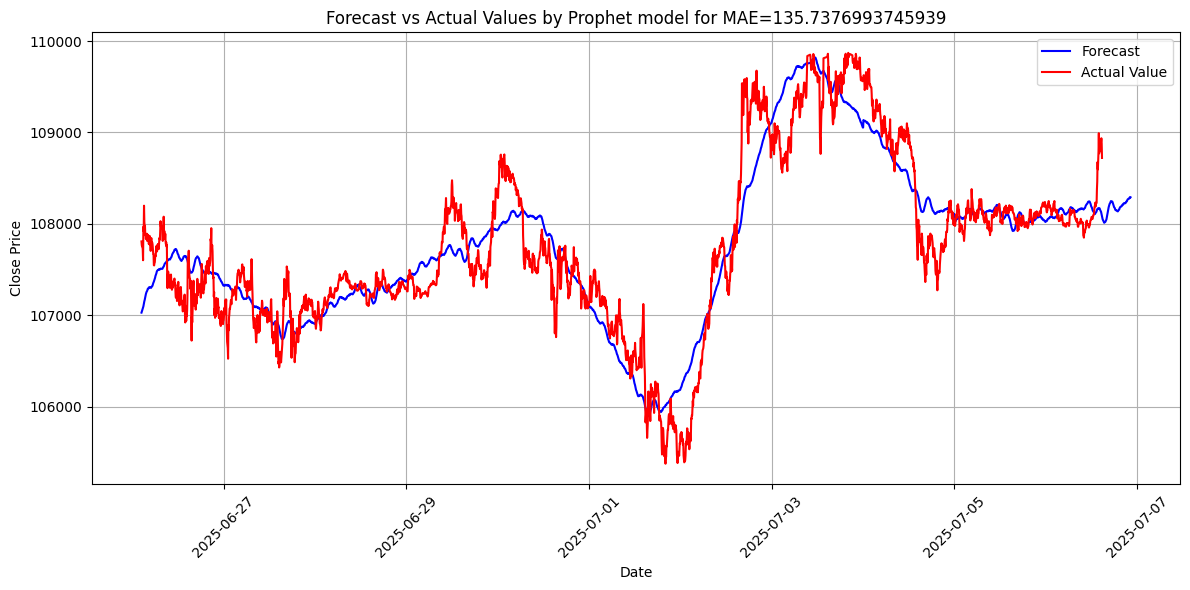

In [24]:
plt.figure(figsize=(12, 6))
result['Close'] = pd.to_numeric(result['Close'])
plt.plot(result['ds'], result['yhat'], 'b-', label='Forecast')
plt.plot(result['ds'], result['Close'], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Close Price')
plt.title(f'Forecast vs Actual Values by Prophet model for MAE={mae}')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
plt.show()

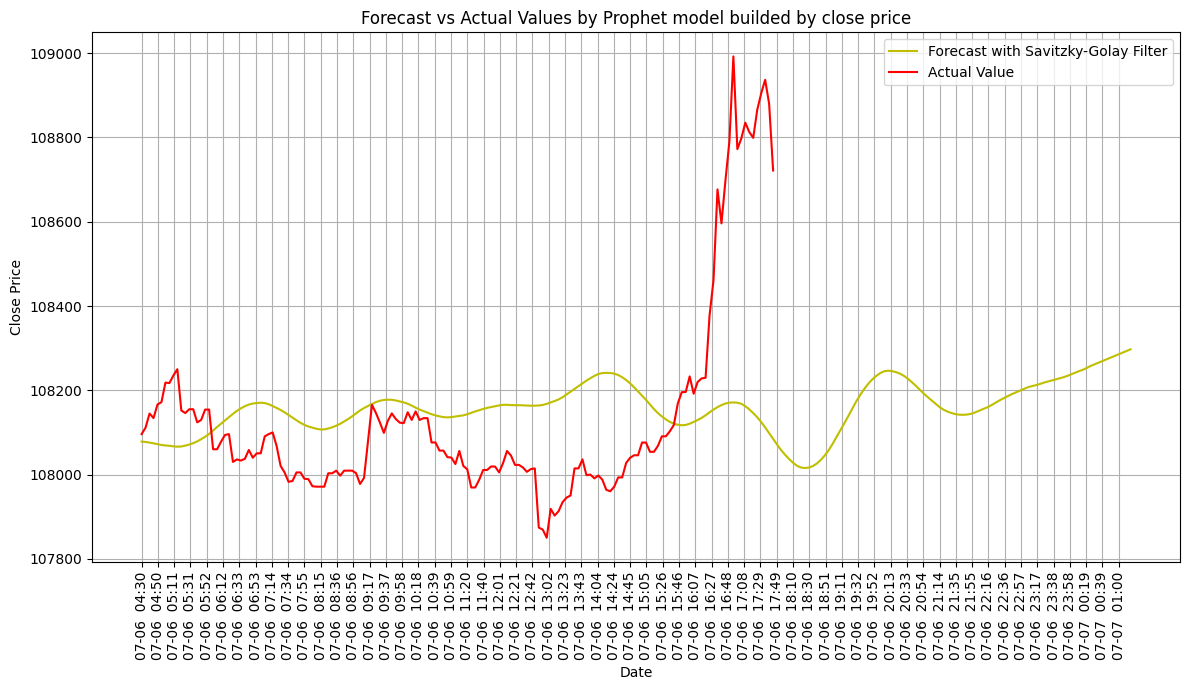

In [25]:
amount_of_5min = 250
plt.figure(figsize=(12, 7))

result['yhat_savgol_filter'] = savgol_filter(result['yhat'], window_length=21, polyorder=2) # to make the yhat smoother

result['Close'] = pd.to_numeric(result['Close'])
result['ds'] = result['ds'] + pd.to_timedelta(3, unit='h') # added + 3h to UTC time
#plt.plot(result['ds'].iloc[-amount_of_5min:], result['yhat'].iloc[-amount_of_5min:], 'b-', label='Forecast')
plt.plot(result['ds'].iloc[-amount_of_5min:], result['yhat_savgol_filter'].iloc[-amount_of_5min:], 'y-', label='Forecast with Savitzky-Golay Filter')
plt.plot(result['ds'].iloc[-amount_of_5min:], result['Close'].iloc[-amount_of_5min:], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')

tick_dates= pd.date_range(start = result['ds'].iloc[-amount_of_5min:].min().ceil('30 min'), 
                          end = result['ds'].iloc[-amount_of_5min:].max().floor('30 min'), 
                          periods = 61)
plt.xticks(tick_dates, rotation=90)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d  %H:%M'))

plt.ylabel('Close Price')
plt.title('Forecast vs Actual Values by Prophet model builded by close price')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
# Save the plot with date and time in the filename
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
plt.savefig(f'{symbol}_forecast_{timestamp}.png')  # Save with timestamp

output_path = os.path.join('..', 'charts', f'5m_{symbol}_forecast_Prophet_{timestamp}.png')

plt.savefig(output_path)

plt.show()

# Plotting partst of the forecast:
-Actual data points (black dots)

-Forecast line (yhat)

-Uncertainty bands (yhat_lower, yhat_upper)

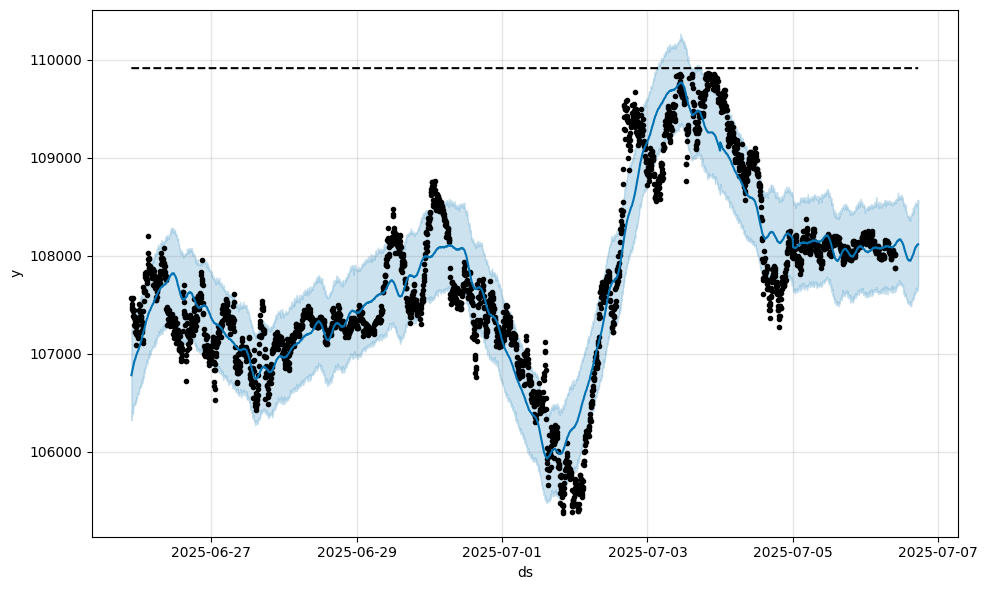

In [10]:
fig1 = m.plot(forecast)
#a = add_changepoints_to_plot(fig1.gca(), m, forecast)
plt.show()

# Visualizes individual model components:

-Trend

-Weekly seasonality

-Yearly seasonality

-Holidays (if added)

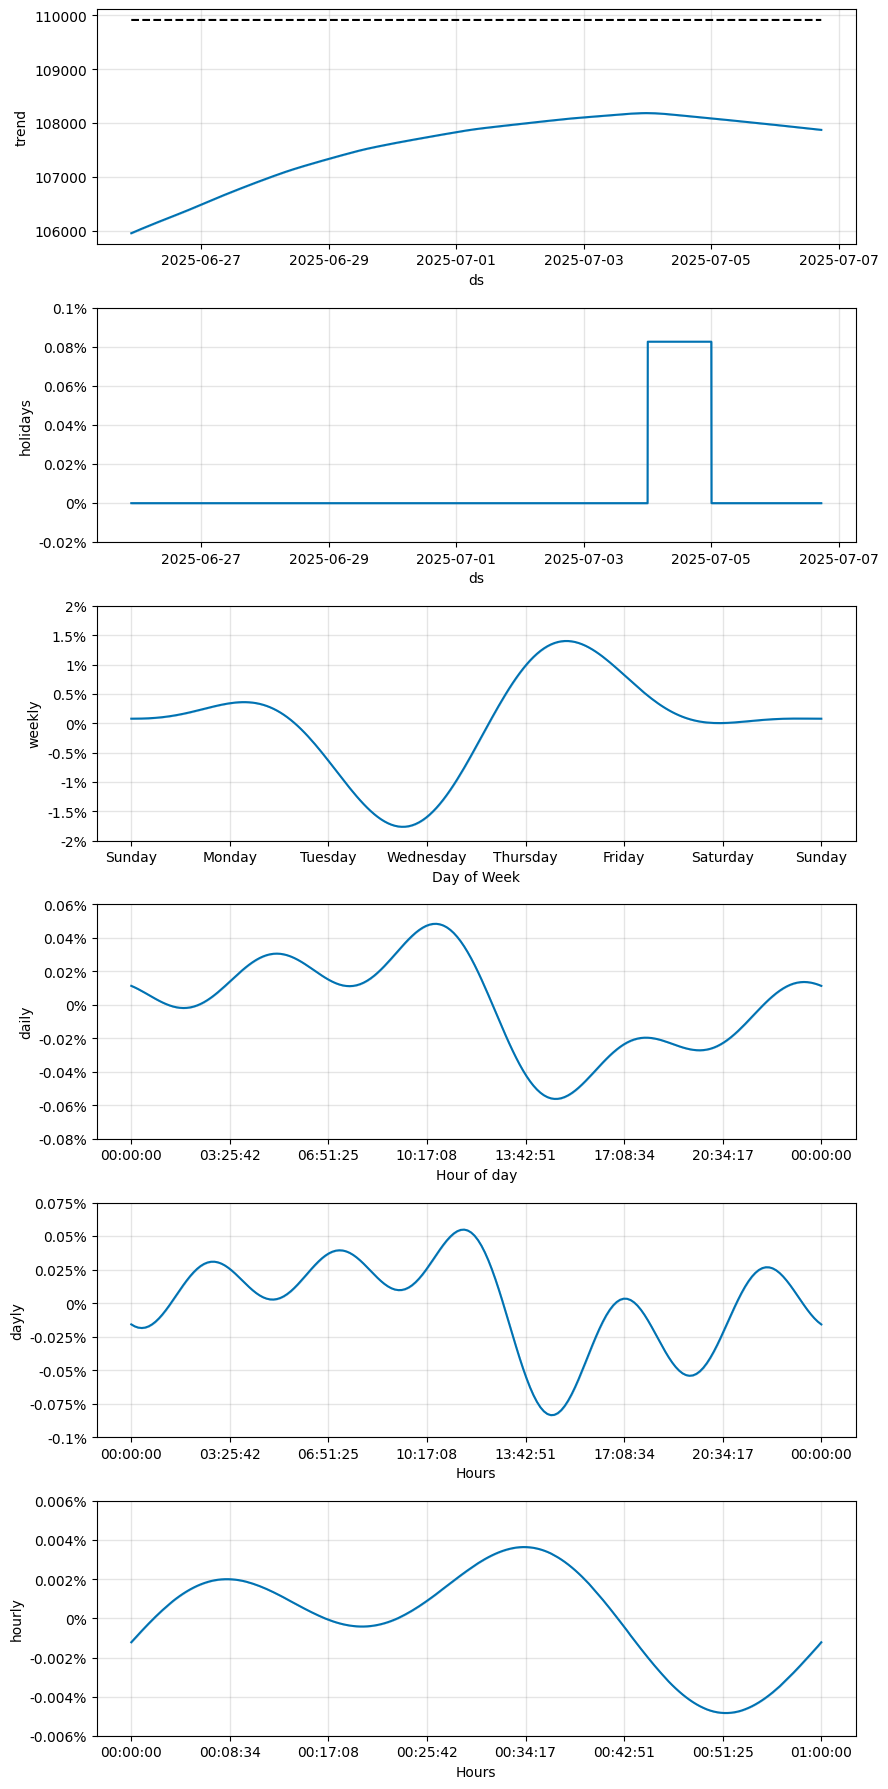

In [11]:
fig2 = m.plot_components(forecast)
plt.show()

In [12]:
result[['ds','yhat','Close','Date']].to_csv('forecast_course.csv' )